<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/Aprofundo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import librosa
import librosa.display
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
!pip install optuna
!pip install optuna-integration
import optuna
from optuna.integration import TFKerasPruningCallback


# Montar el Google Drive en el directorio del proyecto y descomprimir el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/aprendizaje-profundo.zip' >> /dev/null  # ACTUALIZAR: ruta al fichero comprimido


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 3.4 MB/s eta 0:00:00
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Primero, se obtienen las rutas donde están almacenados los datos y se guardan como variables. Una vez hecho esto, se extraen los dataframes asociados a esas direcciones y se almacenan también.

In [2]:
data_path = '/content/NIPS4B'
audiostrain_dir = data_path + "/train/"
csvtrain_file = data_path + "/train.csv"

audiotest_dir = data_path + "/test/"
csvtest_file = data_path + "/test.csv"

class_infodir = data_path + "/class_info.csv"

class_info = pd.read_csv(class_infodir)
dftrain = pd.read_csv(csvtrain_file)
dftest = pd.read_csv(csvtest_file)
dftrain

,filename,start,end,class
0,nips4b_train001.wav,2.975057,3.172426,Petpet_song
1,nips4b_train001.wav,1.967891,2.054966,Sylcan_song
2,nips4b_train001.wav,0.856236,0.937506,Sylcan_song
3,nips4b_train001.wav,1.541224,1.674739,Sylcan_song
4,nips4b_train001.wav,1.843084,1.973696,Sylcan_song
...,...,...,...,...
4583,nips4b_train525.wav,3.662041,3.707755,Poepal_call
4584,nips4b_train525.wav,3.732245,3.877551,Poepal_call
4585,nips4b_train525.wav,4.236735,4.337959,Poepal_call
4586,nips4b_train525.wav,2.091429,2.210612,Unknown


Al observar el dataframe de entrenamiento, podemos apreciar que consta de 4 columnas: en la primera sale el nombre del archivo al que pertenece cada fragmento de canto, las dos siguientes son el inicio y el fin del canto y la última es la relacionada con la clase de ave que emite el canto.


Posteriormente, queremos averiguar el número de clases total que tenemos, también se creará una nueva columna que represente la duración del canto, este dato será relevante para el entrenamiento.

In [3]:
clases = class_info['class name']
clasestotal = clases.to_list()
len(clasestotal)

89

In [4]:
# Calcular la duración de los segmentos de canto
dftrain['duration'] = dftrain['end'] - dftrain['start']
dftrain

,filename,start,end,class,duration
0,nips4b_train001.wav,2.975057,3.172426,Petpet_song,0.197370
1,nips4b_train001.wav,1.967891,2.054966,Sylcan_song,0.087075
2,nips4b_train001.wav,0.856236,0.937506,Sylcan_song,0.081270
3,nips4b_train001.wav,1.541224,1.674739,Sylcan_song,0.133515
4,nips4b_train001.wav,1.843084,1.973696,Sylcan_song,0.130612
...,...,...,...,...,...
4583,nips4b_train525.wav,3.662041,3.707755,Poepal_call,0.045714
4584,nips4b_train525.wav,3.732245,3.877551,Poepal_call,0.145306
4585,nips4b_train525.wav,4.236735,4.337959,Poepal_call,0.101224
4586,nips4b_train525.wav,2.091429,2.210612,Unknown,0.119184


Como indica la salida, hay 89 clases diferentes. Algo indispensable antes de abordar la creación de un modelo es asegurarse de que no hay presentes valores nulos en nuestros datos:

In [5]:
datos_perdidos = dftrain.isnull().sum()
print("Datos nulos: ")
print(datos_perdidos)
# Contar la cantidad de muestras por clase
class_counts = dftrain['class'].value_counts()
print("Número de muestras por clase:")
print(class_counts)

Datos nulos: 
filename    0
start       0
end         0
class       0
duration    0
dtype: int64
Número de muestras por clase:
class
Sylcan_song    201
Unknown        194
Sylund_song    191
Sylmel_call    180
Lularb_song    175
              ... 
Cicorn_song      9
Plasab_song      9
Phycol_call      9
Jyntor_song      9
Cicatr_song      7
Name: count, Length: 89, dtype: int64


No hay presente ningún dato pérdido, también podemos observar las clases con más muestras y con menos en los datos de entrenamiento.

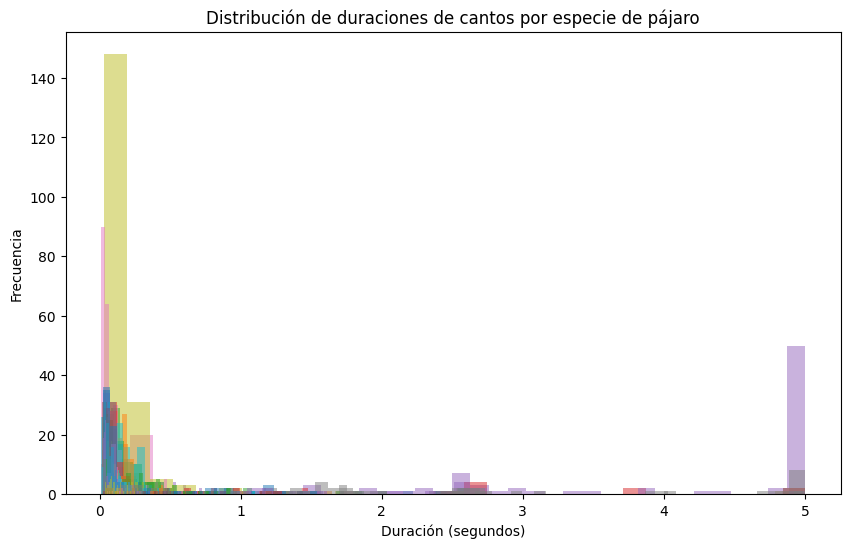

In [6]:
# Histograma de las duraciones de los cantos para cada clase
plt.figure(figsize=(10, 6))
for especie in dftrain['class'].unique():
    durations = dftrain[dftrain['class'] == especie]['duration']
    plt.hist(durations, bins=30, alpha=0.5, label=especie)
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
plt.title('Distribución de duraciones de cantos por especie de pájaro')
plt.show()

Para generar los espectrogramas primero codificamos las clases en formato númerico. Se utiliza "librosa" para cargar el archivo de audio desde la ubicación especificada por audio_dir, "offset"="start_time" y "duration"="end_time" - "start_time" se utilizan para cargar solo la parte del audio especificada por los tiempos de inicio y fin. "librosa.feature.melspectrogram" calcula el espectrograma de Mel del audio cargado. Los parámetros como "n_fft", "hop_length", "n_mels" y "fmax" controlan la configuración del espectrograma.


Un valor más grande de "n_fft" dará mayor resolución en el dominio de la frecuencia pero menor resolución en el dominio del tiempo, "hop_length" especifica el número de muestras entre cada columna del espectrograma, "n_mels" define cuántas bandas Mel se usan para representar el espectrograma de Mel(que es una escala perceptual de frecuencias) y "fmax" especifica la frecuencia máxima que se incluirá en el espectrograma de Mel.

"librosa.power_to_db" convierte el espectrograma de potencia a escala de decibelios (dB), normalizándolo por el valor máximo en el espectrograma.

 Si un espectrograma tiene menos columnas que "mean_length", se realiza padding. Si tiene más columnas, se recorta para ajustarse a "mean_length".

In [22]:
label_encoder = LabelEncoder()
dftrain['class'] = label_encoder.fit_transform(dftrain['class'])

def generar_espectrogramas(dataframe, audio_dir, n_fft=256, hop_length=128, n_mels=32, fmax=8000):
    espectrogramas = []
    longitudes = []

    for index, row in dataframe.iterrows():
        audio_file = os.path.join(audio_dir, row['filename'])
        start_time = row['start']
        end_time = row['end']

        try:
            # Cargar el archivo de audio
            y, sr = librosa.load(audio_file, sr=None, offset=start_time, duration=end_time - start_time)

            # Calcular el espectrograma de Mel
            espectrograma = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)

            # Convertir a dB
            espectrograma_db = librosa.power_to_db(espectrograma, ref=np.max)

            # Guardar la longitud del espectrograma(Esto es útil para calcular la longitud media posteriormente).
            longitudes.append(espectrograma_db.shape[1])

            # Agregar el espectrograma a la lista junto con la clase y otra información relevante
            espectrogramas.append((espectrograma_db, row['class'], start_time, end_time))

        except Exception as e:
            print(f"Error processing {audio_file}: {e}")

    # Calcular la longitud media
    longitud_media = int(np.mean(longitudes))

    # Ajustar los espectrogramas a la longitud media
    espectrogramas_ajustados = []
    for spectrogram, label, start_time, end_time in espectrogramas:
        if spectrogram.shape[1] < longitud_media:
            # Padding
            pad_anchura = longitud_media - spectrogram.shape[1]
            espectrograma_padded = np.pad(spectrogram, ((0, 0), (0, pad_anchura)), mode='constant')
        else:
            # Recortar
            espectrograma_padded = spectrogram[:, :longitud_media]

        espectrogramas_ajustados.append((espectrograma_padded, label, start_time, end_time))

    return espectrogramas_ajustados, longitud_media

Se obtienen los espectrogramas y se agrega la duración correspondiente de cada uno para que el modelo de aprendizaje tenga dicha información, también se comprueba que el tamaño de todos los espectrogramas sea idéntico, esto es necesario para el posterior entrenamiento:


In [8]:
# Ejemplo simplificado de cómo podrías generar espectrogramas con duración
espectrogramas, longitud_media = generar_espectrogramas(dftrain, audiostrain_dir, n_fft=256, hop_length=128)

# Asegúrate de que cada espectrograma tenga su duración correspondiente
for idx, (spec, label, start_time, end_time) in enumerate(espectrogramas):
    duration = dftrain.iloc[idx]['duration']
    espectrogramas[idx] = (spec, label, start_time, end_time, duration)


In [9]:
# Verificar tamaños de los espectrogramas
def comprobar_tamaños(espectrogramas):
    shapes = [spectrogram.shape for spectrogram, _, _, _, _ in espectrogramas]
    unique_shapes = set(shapes)
    return unique_shapes

# Llamar a la función y verificar
unique_shapes = comprobar_tamaños(espectrogramas)

if len(unique_shapes) == 1:
    print(f"Todos los espectrogramas tienen el mismo tamaño: {unique_shapes.pop()}")
else:
    print(f"Los espectrogramas tienen diferentes tamaños: {unique_shapes}")


Todos los espectrogramas tienen el mismo tamaño: (32, 92)


Se representa visualmente un espectrograma, en este caso es el segundo de la lista que tenemos:

Tamaño de los datos de entrada: (4588, 32, 92)
Tamaño de las etiquetas: (4588,)


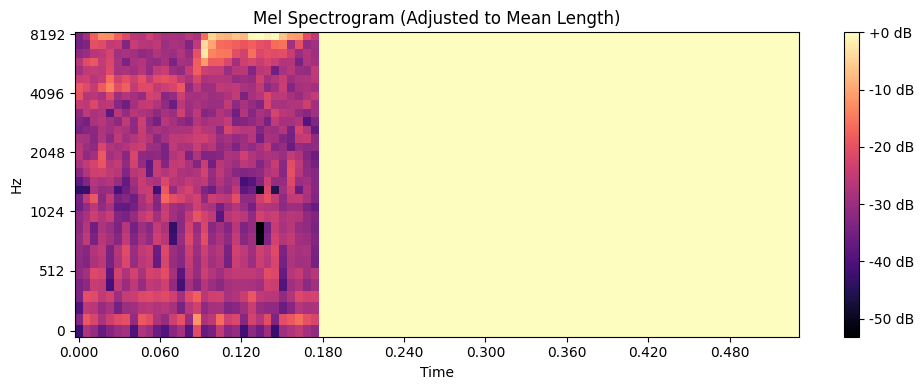

In [10]:
# Convertir a un formato numpy adecuado para el entrenamiento
X = np.array([item[0] for item in espectrogramas])
y = np.array([item[1] for item in espectrogramas])

print(f"Tamaño de los datos de entrada: {X.shape}")
print(f"Tamaño de las etiquetas: {y.shape}")

# Verificación visual de un espectrograma
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[1], hop_length=128, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (Adjusted to Mean Length)')
plt.tight_layout()
plt.show()

Aparte, se revisa el contenido de cada uno, tenemos lo siguiente:


*   El espectrograma en sí.

*   La etiqueta(tipo de canto) en forma númerica.

*   El inicio del canto.
*   El final del canto.


*   La duración del canto.








In [11]:
espectrogramas[0]

(array([[-14.060253 , -14.332951 , -13.267925 , ...,   0.       ,
           0.       ,   0.       ],
        [ -5.2133827,  -5.48608  ,  -4.421055 , ...,   0.       ,
           0.       ,   0.       ],
        [-15.7290535, -18.568386 ,  -6.054512 , ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [-14.073887 , -14.507931 , -17.012554 , ...,   0.       ,
           0.       ,   0.       ],
        [-18.891804 , -17.371212 , -17.993847 , ...,   0.       ,
           0.       ,   0.       ],
        [-23.022778 , -16.369343 , -17.179028 , ...,   0.       ,
           0.       ,   0.       ]], dtype=float32),
 52,
 2.975056689,
 3.172426304,
 0.19736961499999994)

A continuación, se construye el modelo y se entrena, para optimizar los hiperparámetros se implementará optuna:

In [20]:
# Asumimos que 'espectrogramas' contiene los espectrogramas ajustados con sus etiquetas de duración y clase.
X = np.array([spec for spec, label, _, _, _ in espectrogramas])
y_duration = np.array([duration for _, _, _, _, duration in espectrogramas])
y_class = np.array([label for _, label, _, _, _ in espectrogramas])

# Dividir en conjuntos de entrenamiento y prueba para ambas tareas
X_train, X_test, y_duration_train, y_duration_test, y_class_train, y_class_test = train_test_split(X, y_duration, y_class, test_size=0.2, random_state=42)

# Añadir una dimensión de canal para que sea compatible con Conv2D
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

def create_model(trial):
    input_shape = X_train.shape[1:]

    # Definir la arquitectura del modelo con hiperparámetros sugeridos por Optuna
    inputs = Input(shape=input_shape)

    # Primera capa convolucional
    x = Conv2D(trial.suggest_int('filters_1', 16, 64), kernel_size=(3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Segunda capa convolucional
    x = Conv2D(trial.suggest_int('filters_2', 32, 128), kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Tercera capa convolucional
    x = Conv2D(trial.suggest_int('filters_3', 64, 256), kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Capas completamente conectadas para la salida de duración
    x_duration = Flatten()(x)
    x_duration = Dense(trial.suggest_int('units_duration', 128, 512), activation='relu')(x_duration)
    x_duration = Dropout(trial.suggest_float('dropout_duration', 0.3, 0.7))(x_duration)
    x_duration = BatchNormalization()(x_duration)
    output_duration = Dense(1, name='output_duration')(x_duration)

    # Capas completamente conectadas para la salida de clase
    x_class = Flatten()(x)
    x_class = Dense(trial.suggest_int('units_class', 128, 512), activation='relu')(x_class)
    x_class = Dropout(trial.suggest_float('dropout_class', 0.3, 0.7))(x_class)
    x_class = BatchNormalization()(x_class)
    output_class = Dense(89, activation='softmax', name='output_class')(x_class)  # num_species es el número de clases de aves

    # Modelo final.
    model = Model(inputs=inputs, outputs=[output_duration, output_class])

    # Compilación del modelo con pérdidas y métricas específicas para cada salida.
    model.compile(optimizer='adam',
                  loss={'output_duration': 'mse', 'output_class': 'sparse_categorical_crossentropy'},
                  metrics={'output_duration': 'mae', 'output_class': 'accuracy'})

    return model

def objective(trial):
    model = create_model(trial)

    # Implementación de Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

    history = model.fit(X_train, {'output_duration': y_duration_train, 'output_class': y_class_train},
                        epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, pruning_callback])

    # Evaluación del modelo
    loss_and_metrics = model.evaluate(X_test, {'output_duration': y_duration_test, 'output_class': y_class_test}, verbose=0)
    return loss_and_metrics[0]  # Retornar la pérdida total como métrica a optimizar

# Crear el estudio de Optuna y optimizar los hiperparámetros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print(f"Best trial: {study.best_trial.value}")
print("Best hyperparameters: ", study.best_trial.params)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el mejor modelo con los mejores hiperparámetros encontrados
best_model = create_model(study.best_trial)
history = best_model.fit(X_train, {'output_duration': y_duration_train, 'output_class': y_class_train},
                         epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


[I 2024-06-25 14:31:53,916] A new study created in memory with name: no-name-75292cf0-e1cf-41a9-97e9-6277709910a7


Epoch 1/100
92/92 [==============================] - 9s 26ms/step - loss: 6.0826 - output_duration_loss: 1.5651 - output_class_loss: 4.5174 - output_duration_mae: 0.9498 - output_class_accuracy: 0.0559 - val_loss: 4.7140 - val_output_duration_loss: 0.5280 - val_output_class_loss: 4.1860 - val_output_duration_mae: 0.2776 - val_output_class_accuracy: 0.0640
Epoch 2/100
92/92 [==============================] - 1s 15ms/step - loss: 4.9318 - output_duration_loss: 0.8764 - output_class_loss: 4.0553 - output_duration_mae: 0.6817 - output_class_accuracy: 0.0937 - val_loss: 4.7071 - val_output_duration_loss: 0.7926 - val_output_class_loss: 3.9145 - val_output_duration_mae: 0.5524 - val_output_class_accuracy: 0.0926
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 4.4557 - output_duration_loss: 0.6215 - output_class_loss: 3.8342 - output_duration_mae: 0.5378 - output_class_accuracy: 0.1236 - val_loss: 4.0824 - val_output_duration_loss: 0.3601 - val_output_class_loss: 3.7

[I 2024-06-25 14:32:19,076] Trial 0 finished with value: 3.2008941173553467 and parameters: {'filters_1': 26, 'filters_2': 61, 'filters_3': 228, 'units_duration': 442, 'dropout_duration': 0.6774443699289329, 'units_class': 225, 'dropout_class': 0.4476462949690947}. Best is trial 0 with value: 3.2008941173553467.


Epoch 1/100
92/92 [==============================] - 7s 19ms/step - loss: 6.4535 - output_duration_loss: 1.7971 - output_class_loss: 4.6564 - output_duration_mae: 0.9778 - output_class_accuracy: 0.0514 - val_loss: 5.1092 - val_output_duration_loss: 1.0588 - val_output_class_loss: 4.0504 - val_output_duration_mae: 0.8024 - val_output_class_accuracy: 0.0654
Epoch 2/100
92/92 [==============================] - 1s 10ms/step - loss: 5.1754 - output_duration_loss: 0.9060 - output_class_loss: 4.2694 - output_duration_mae: 0.7013 - output_class_accuracy: 0.0691 - val_loss: 4.3713 - val_output_duration_loss: 0.4795 - val_output_class_loss: 3.8918 - val_output_duration_mae: 0.4745 - val_output_class_accuracy: 0.0940
Epoch 3/100
92/92 [==============================] - 1s 11ms/step - loss: 4.7524 - output_duration_loss: 0.7302 - output_class_loss: 4.0222 - output_duration_mae: 0.6043 - output_class_accuracy: 0.1107 - val_loss: 4.3926 - val_output_duration_loss: 0.5651 - val_output_class_loss: 3.8

[I 2024-06-25 14:33:04,004] Trial 1 finished with value: 3.0669822692871094 and parameters: {'filters_1': 16, 'filters_2': 101, 'filters_3': 243, 'units_duration': 167, 'dropout_duration': 0.5130537261004514, 'units_class': 425, 'dropout_class': 0.692315751520719}. Best is trial 1 with value: 3.0669822692871094.


Epoch 1/100
92/92 [==============================] - 6s 18ms/step - loss: 6.0741 - output_duration_loss: 1.5352 - output_class_loss: 4.5389 - output_duration_mae: 0.9280 - output_class_accuracy: 0.0586 - val_loss: 6.7411 - val_output_duration_loss: 2.5144 - val_output_class_loss: 4.2267 - val_output_duration_mae: 0.8798 - val_output_class_accuracy: 0.0763
Epoch 2/100
92/92 [==============================] - 1s 10ms/step - loss: 4.8953 - output_duration_loss: 0.8450 - output_class_loss: 4.0502 - output_duration_mae: 0.6639 - output_class_accuracy: 0.1100 - val_loss: 4.3688 - val_output_duration_loss: 0.4082 - val_output_class_loss: 3.9606 - val_output_duration_mae: 0.3114 - val_output_class_accuracy: 0.0763
Epoch 3/100
92/92 [==============================] - 1s 10ms/step - loss: 4.3852 - output_duration_loss: 0.5915 - output_class_loss: 3.7937 - output_duration_mae: 0.5150 - output_class_accuracy: 0.1413 - val_loss: 4.3127 - val_output_duration_loss: 0.4782 - val_output_class_loss: 3.8

[I 2024-06-25 14:33:36,559] Trial 2 finished with value: 3.058567523956299 and parameters: {'filters_1': 29, 'filters_2': 45, 'filters_3': 126, 'units_duration': 371, 'dropout_duration': 0.48220229129918657, 'units_class': 232, 'dropout_class': 0.556396285169817}. Best is trial 2 with value: 3.058567523956299.


Epoch 1/100
92/92 [==============================] - 6s 19ms/step - loss: 6.0076 - output_duration_loss: 1.3319 - output_class_loss: 4.6758 - output_duration_mae: 0.8643 - output_class_accuracy: 0.0422 - val_loss: 4.6382 - val_output_duration_loss: 0.5368 - val_output_class_loss: 4.1014 - val_output_duration_mae: 0.5116 - val_output_class_accuracy: 0.0817
Epoch 2/100
92/92 [==============================] - 1s 13ms/step - loss: 5.0476 - output_duration_loss: 0.8345 - output_class_loss: 4.2131 - output_duration_mae: 0.6548 - output_class_accuracy: 0.0814 - val_loss: 4.3089 - val_output_duration_loss: 0.3632 - val_output_class_loss: 3.9457 - val_output_duration_mae: 0.2907 - val_output_class_accuracy: 0.0858
Epoch 3/100
92/92 [==============================] - 1s 14ms/step - loss: 4.5805 - output_duration_loss: 0.6016 - output_class_loss: 3.9789 - output_duration_mae: 0.5474 - output_class_accuracy: 0.1104 - val_loss: 4.2410 - val_output_duration_loss: 0.4197 - val_output_class_loss: 3.8

[I 2024-06-25 14:34:20,277] Trial 3 finished with value: 3.099135160446167 and parameters: {'filters_1': 20, 'filters_2': 125, 'filters_3': 135, 'units_duration': 181, 'dropout_duration': 0.3172662805889117, 'units_class': 284, 'dropout_class': 0.6780709751348443}. Best is trial 2 with value: 3.058567523956299.


Epoch 1/100
92/92 [==============================] - 7s 25ms/step - loss: 6.2381 - output_duration_loss: 1.6862 - output_class_loss: 4.5519 - output_duration_mae: 0.9674 - output_class_accuracy: 0.0501 - val_loss: 8.1173 - val_output_duration_loss: 3.4126 - val_output_class_loss: 4.7046 - val_output_duration_mae: 1.0925 - val_output_class_accuracy: 0.0913
Epoch 2/100
92/92 [==============================] - 1s 16ms/step - loss: 5.1261 - output_duration_loss: 0.9939 - output_class_loss: 4.1322 - output_duration_mae: 0.7157 - output_class_accuracy: 0.0865 - val_loss: 4.3582 - val_output_duration_loss: 0.4019 - val_output_class_loss: 3.9563 - val_output_duration_mae: 0.3558 - val_output_class_accuracy: 0.1185
Epoch 3/100
92/92 [==============================] - 1s 11ms/step - loss: 4.5968 - output_duration_loss: 0.6901 - output_class_loss: 3.9067 - output_duration_mae: 0.5685 - output_class_accuracy: 0.1182 - val_loss: 4.3907 - val_output_duration_loss: 0.4574 - val_output_class_loss: 3.9

[I 2024-06-25 14:35:03,950] Trial 4 finished with value: 3.090658187866211 and parameters: {'filters_1': 45, 'filters_2': 80, 'filters_3': 196, 'units_duration': 401, 'dropout_duration': 0.6204411090457504, 'units_class': 260, 'dropout_class': 0.4628442162501376}. Best is trial 2 with value: 3.058567523956299.


Best trial: 3.058567523956299
Best hyperparameters:  {'filters_1': 29, 'filters_2': 45, 'filters_3': 126, 'units_duration': 371, 'dropout_duration': 0.48220229129918657, 'units_class': 232, 'dropout_class': 0.556396285169817}
Epoch 1/100
92/92 [==============================] - 11s 25ms/step - loss: 6.2043 - output_duration_loss: 1.6257 - output_class_loss: 4.5786 - output_duration_mae: 0.9447 - output_class_accuracy: 0.0507 - val_loss: 4.9422 - val_output_duration_loss: 0.7509 - val_output_class_loss: 4.1913 - val_output_duration_mae: 0.4995 - val_output_class_accuracy: 0.0872
Epoch 2/100
92/92 [==============================] - 2s 18ms/step - loss: 4.9841 - output_duration_loss: 0.8834 - output_class_loss: 4.1007 - output_duration_mae: 0.6717 - output_class_accuracy: 0.0950 - val_loss: 4.4161 - val_output_duration_loss: 0.4678 - val_output_class_loss: 3.9483 - val_output_duration_mae: 0.3472 - val_output_class_accuracy: 0.0899
Epoch 3/100
92/92 [==============================] - 1s 1

Evaluamos el modelo:

In [21]:
loss_and_metrics = best_model.evaluate(X_test, {'output_duration': y_duration_test, 'output_class': y_class_test})
print(f"Test Loss: {loss_and_metrics[0]}")
print(f"Test MAE: {loss_and_metrics[3]}")
print(f"Test Accuracy: {loss_and_metrics[4]}")

29/29 [==============================] - 0s 6ms/step - loss: 3.0721 - output_duration_loss: 0.2802 - output_class_loss: 2.7919 - output_duration_mae: 0.2452 - output_class_accuracy: 0.2898
Test Loss: 3.0720653533935547
Test MAE: 0.24517011642456055
Test Accuracy: 0.2897603511810303





Una vez entrenado el modelo se vuelven a crear espectrogramas, esta vez para el conjunto de test, manteniendo los parámetros que se usaron con el conjunto de entrenamiento:

In [49]:
# Función para generar múltiples espectrogramas de la misma longitud para archivos de prueba
def generate_test_spectrograms(test_df, test_data_path, mean_length, num_segments=10, n_fft=256, hop_length=128, n_mels=32, fmax=8000):
    spectrograms = []
    filenames = []
    segment_start_times = []
    segment_end_times = []

    for index, row in test_df.iterrows():
        audio_file = os.path.join(test_data_path, row['filename'])

        try:
            # Cargar el archivo de audio completo
            y, sr = librosa.load(audio_file, sr=None)

            # Dividir el audio en segmentos
            segment_duration = len(y) / num_segments
            segment_starts = np.arange(0, len(y), int(segment_duration))

            for start in segment_starts:
                end = int(start + segment_duration)
                y_segment = y[start:end]

                # Calcular el espectrograma de Mel
                spectrogram = librosa.feature.melspectrogram(y=y_segment, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)

                # Convertir a dB
                spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

                # Ajustar el espectrograma a la longitud media
                if spectrogram_db.shape[1] < mean_length:
                    # Padding
                    pad_width = mean_length - spectrogram_db.shape[1]
                    spectrogram_padded = np.pad(spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    # Recortar
                    spectrogram_padded = spectrogram_db[:, :mean_length]

                # Guardar el espectrograma, el nombre del archivo y los tiempos de inicio y fin del segmento
                spectrograms.append(spectrogram_padded)
                filenames.append(row['filename'])
                segment_start_times.append(start / sr)  # Convertir a tiempo en segundos
                segment_end_times.append(end / sr)      # Convertir a tiempo en segundos

        except Exception as e:
            print(f"Error processing {audio_file}: {e}")

    return np.array(spectrograms), filenames, segment_start_times, segment_end_times

# Obtener espectrogramas, nombres de archivo y tiempos de inicio/fin de segmento de prueba
num_segments = 5  # Número de segmentos por archivo de prueba
test_spectrograms, test_filenames, test_segment_start_times, test_segment_end_times = generate_test_spectrograms(dftest, audiotest_dir, longitud_media, num_segments)

# Añadir una dimensión de canal para que sea compatible con Conv2D
test_spectrograms = test_spectrograms[..., np.newaxis]


# Predecir con el modelo entrenado
predictions_duration, predictions_class = best_model.predict(test_spectrograms)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=2
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=1
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=4
  warnings.warn(


28/28 [==============================] - 0s 5ms/step


Se comprueba que ambas listas que contienen las predicciones tienen igual longitud:

In [50]:
predicted_classes = np.argmax(predictions_class, axis=1)
if len(predicted_classes) == len(predictions_duration):
  print(True)
#Para cada fila (que representa un segmento de audio), argmax devuelve el índice de la clase con la probabilidad más alta.

True


In [55]:
# DataFrame de resultados
label_encoder = LabelEncoder()
label_encoder.fit(y_class)  # y_class contiene todas las etiquetas de clases
class_labels = label_encoder.classes_
results_df = pd.DataFrame(columns=['filename'] + list(class_labels))

# Filas del DataFrame de resultados
for i in range(len(dftest)):
    filename_predictions = [dftest.at[i, 'filename']] + [0.0] * len(class_labels)
    results_df.loc[i] = filename_predictions

# Se calcula la duración total para cada clase y archivo
for i, filename in enumerate(test_filenames):
    filename_index = results_df[results_df['filename'] == filename].index[0]

    # Obtenemos las predicciones de clase y duración para todos los segmentos de este archivo
    segment_indices = [idx for idx, f in enumerate(test_filenames) if f == filename]
    for idx in segment_indices:
        predicted_class = np.argmax(predictions_class[idx])
        predicted_duration = predictions_duration[idx][0]
        class_label = label_encoder.inverse_transform([predicted_class])[0]

        if predicted_duration >= 0:
            # Sumamos la duración predicha a la clase correspondiente en el DataFrame de resultados
            results_df.at[filename_index, class_label] += predicted_duration

# Almacenamos el DataFrame de resultados
results_df.columns = ['filenames'] + clasestotal
# Guardamos los resultados en un archivo CSV
results_csv_file = '/content/NIPS4B/results.csv'
results_df.to_csv(results_csv_file, index=False)

print("Resultados guardados en", results_csv_file)

Resultados guardados en /content/NIPS4B/results.csv
